In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd()
if (ROOT / "src").exists() is False and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.viz import *
from src.utils import *
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier 
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split

Data

In [3]:
store_sales = pd.read_csv(
    ROOT / 'Data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()


family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)


In [4]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

Text(0.5, 1.0, 'Sales of School and Office Supplies (deseasonalized)')

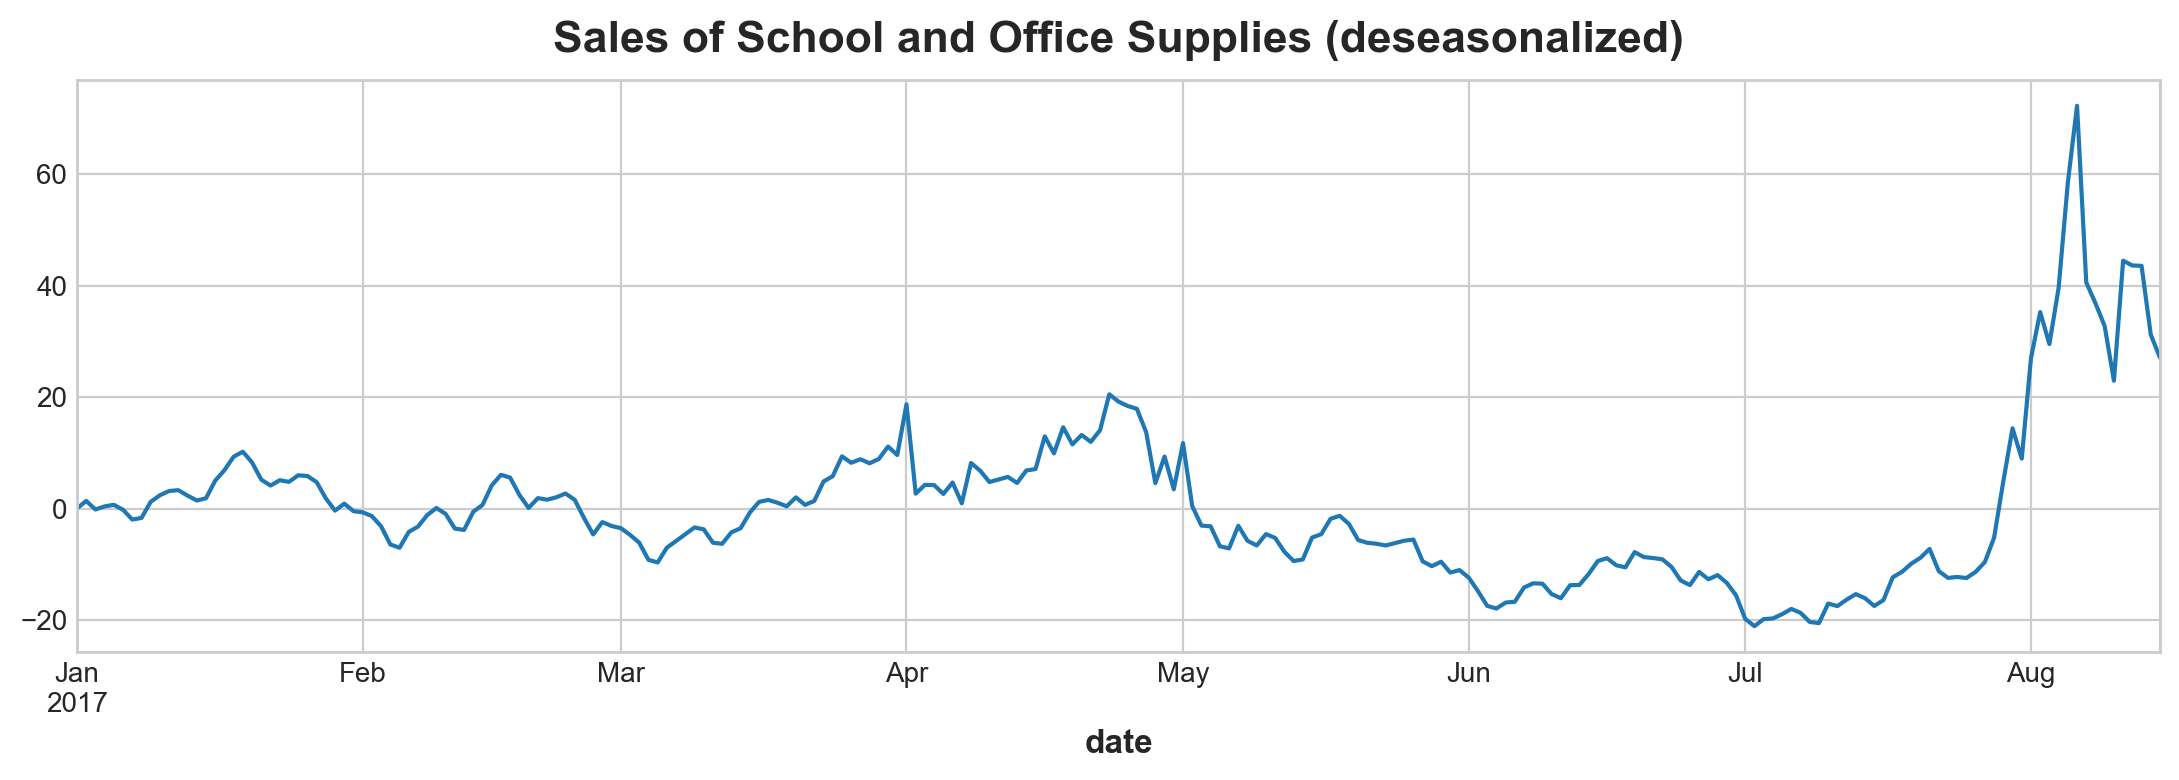

In [5]:
supply_sales = family_sales.loc(axis=1)[:,'SCHOOL AND OFFICE SUPPLIES']

y = supply_sales.loc[:,'sales'].squeeze()

fourier = CalendarFourier(freq = 'M', order = 4)

dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order = 1,
    seasonal=True,
    additional_terms=[fourier],
    drop = True,
)

X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time,y)

y_pred = pd.Series(model.predict(X_time), index = X_time.index)
y_deseason = y - y_pred
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)")

Plot cycles : 7 days moving average

Text(0.5, 1.0, 'Seven-Day Moving Average')

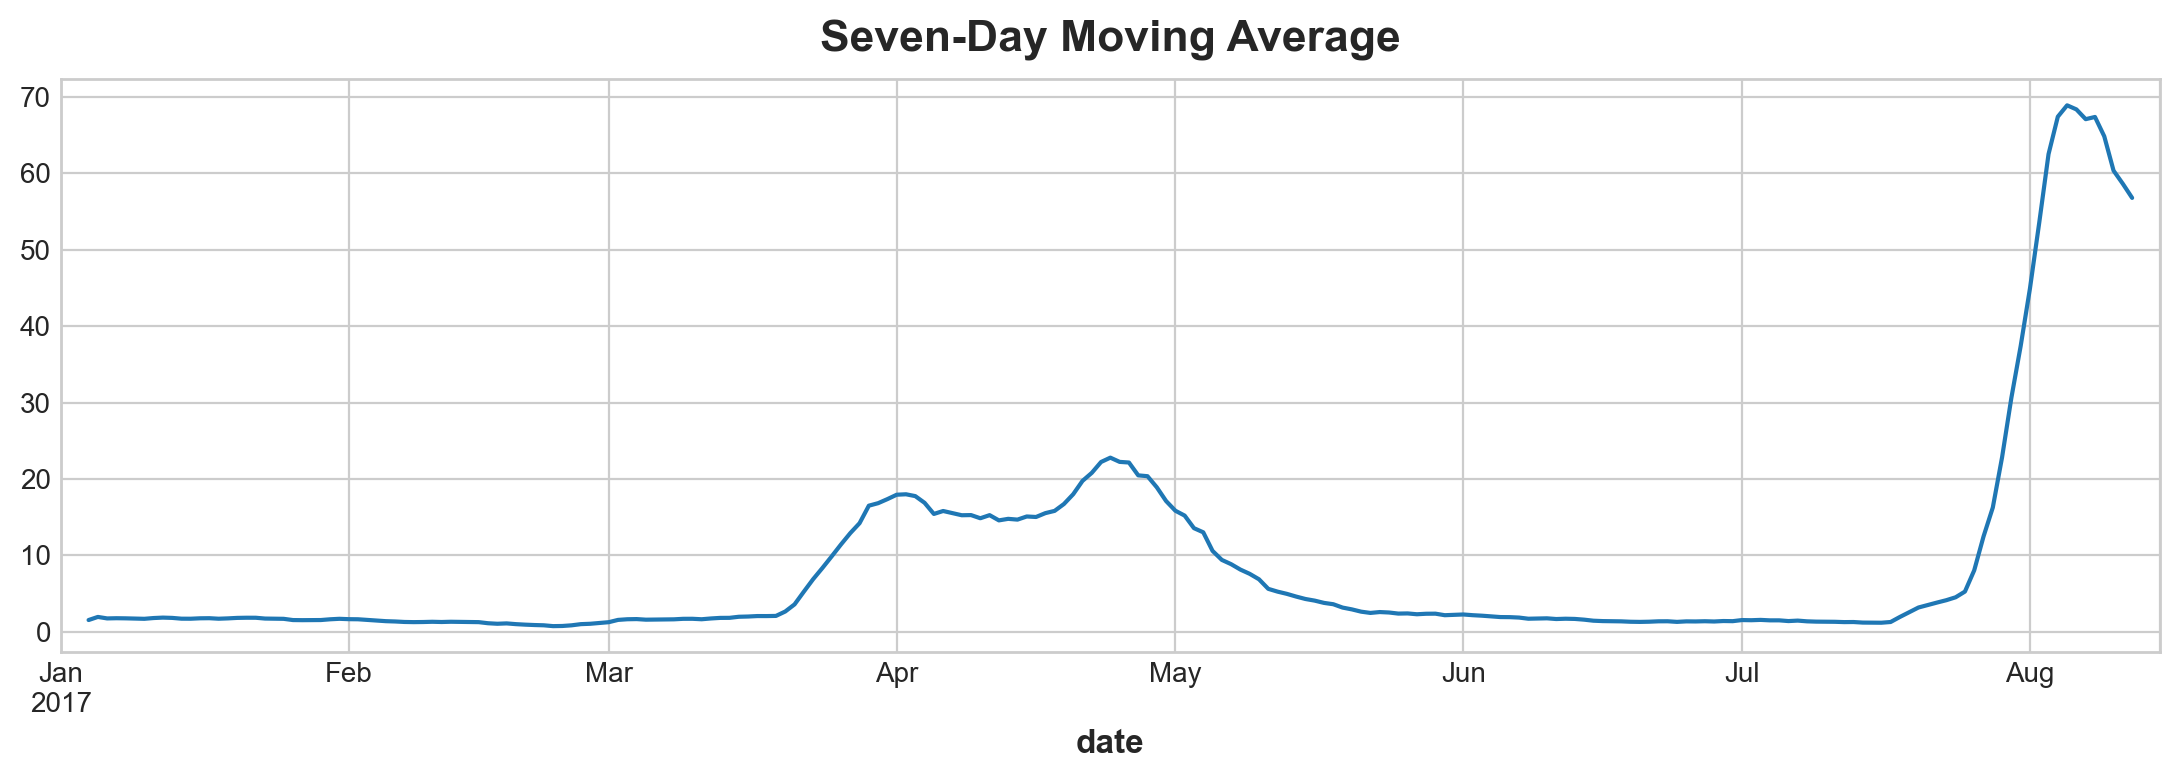

In [6]:
y_ma = y.rolling(
    window = 7,
    center = True,
    ).mean()

# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average")

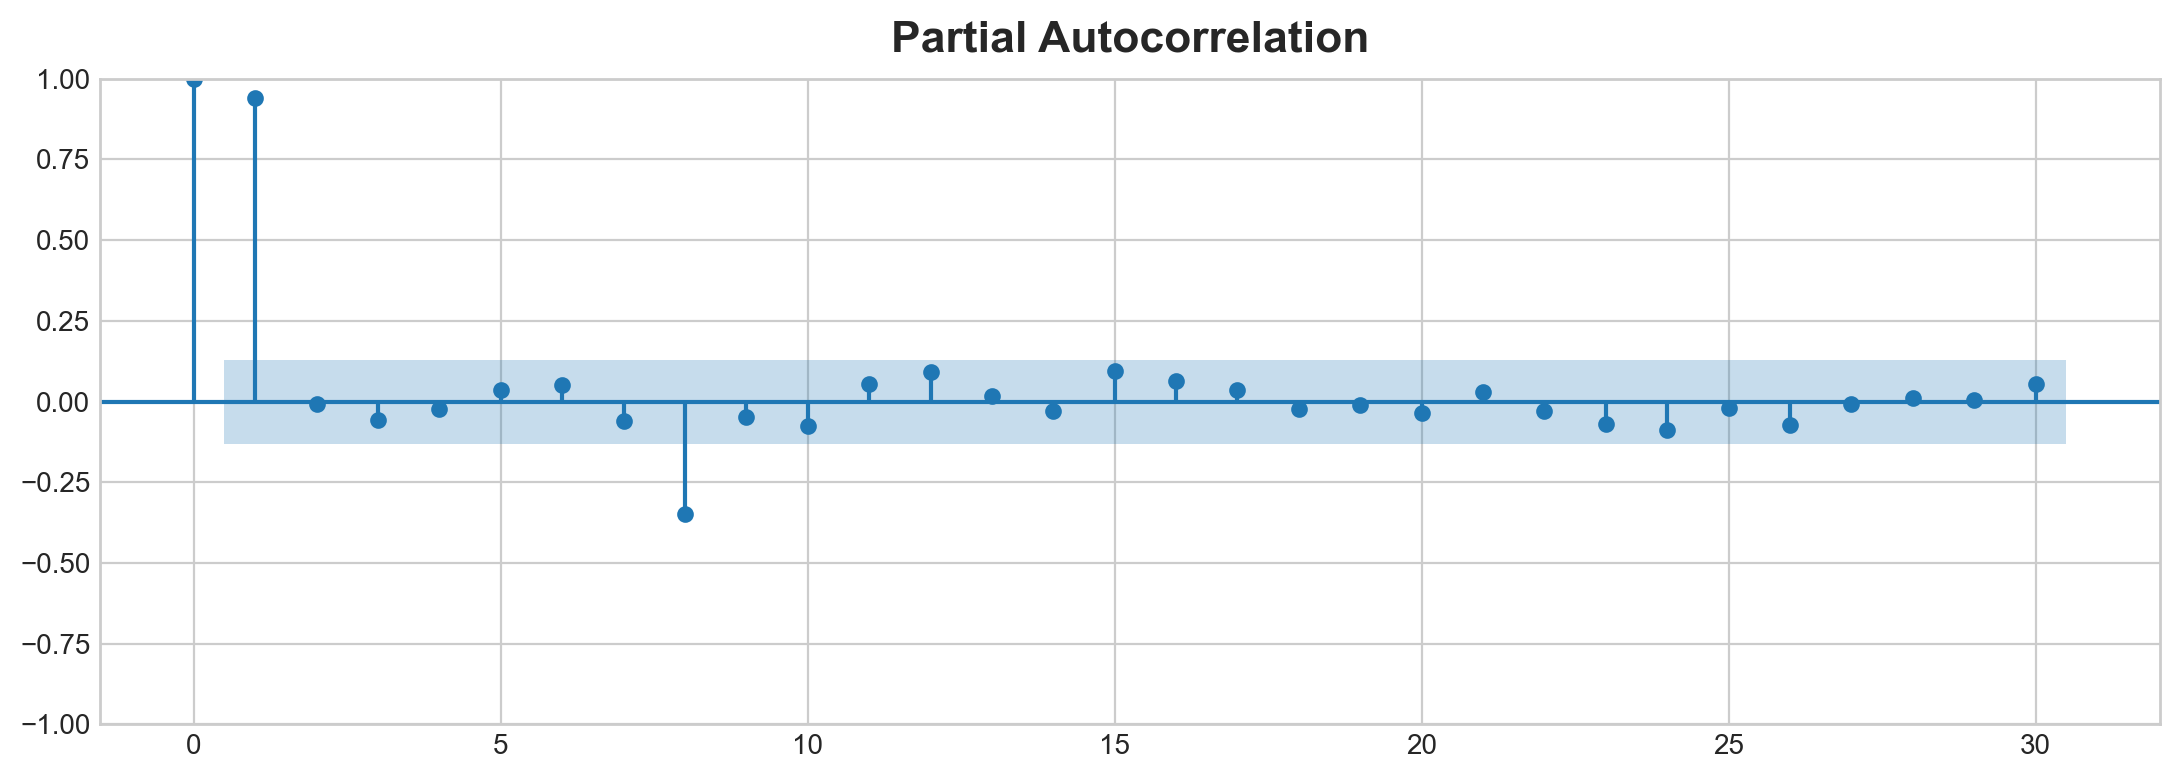

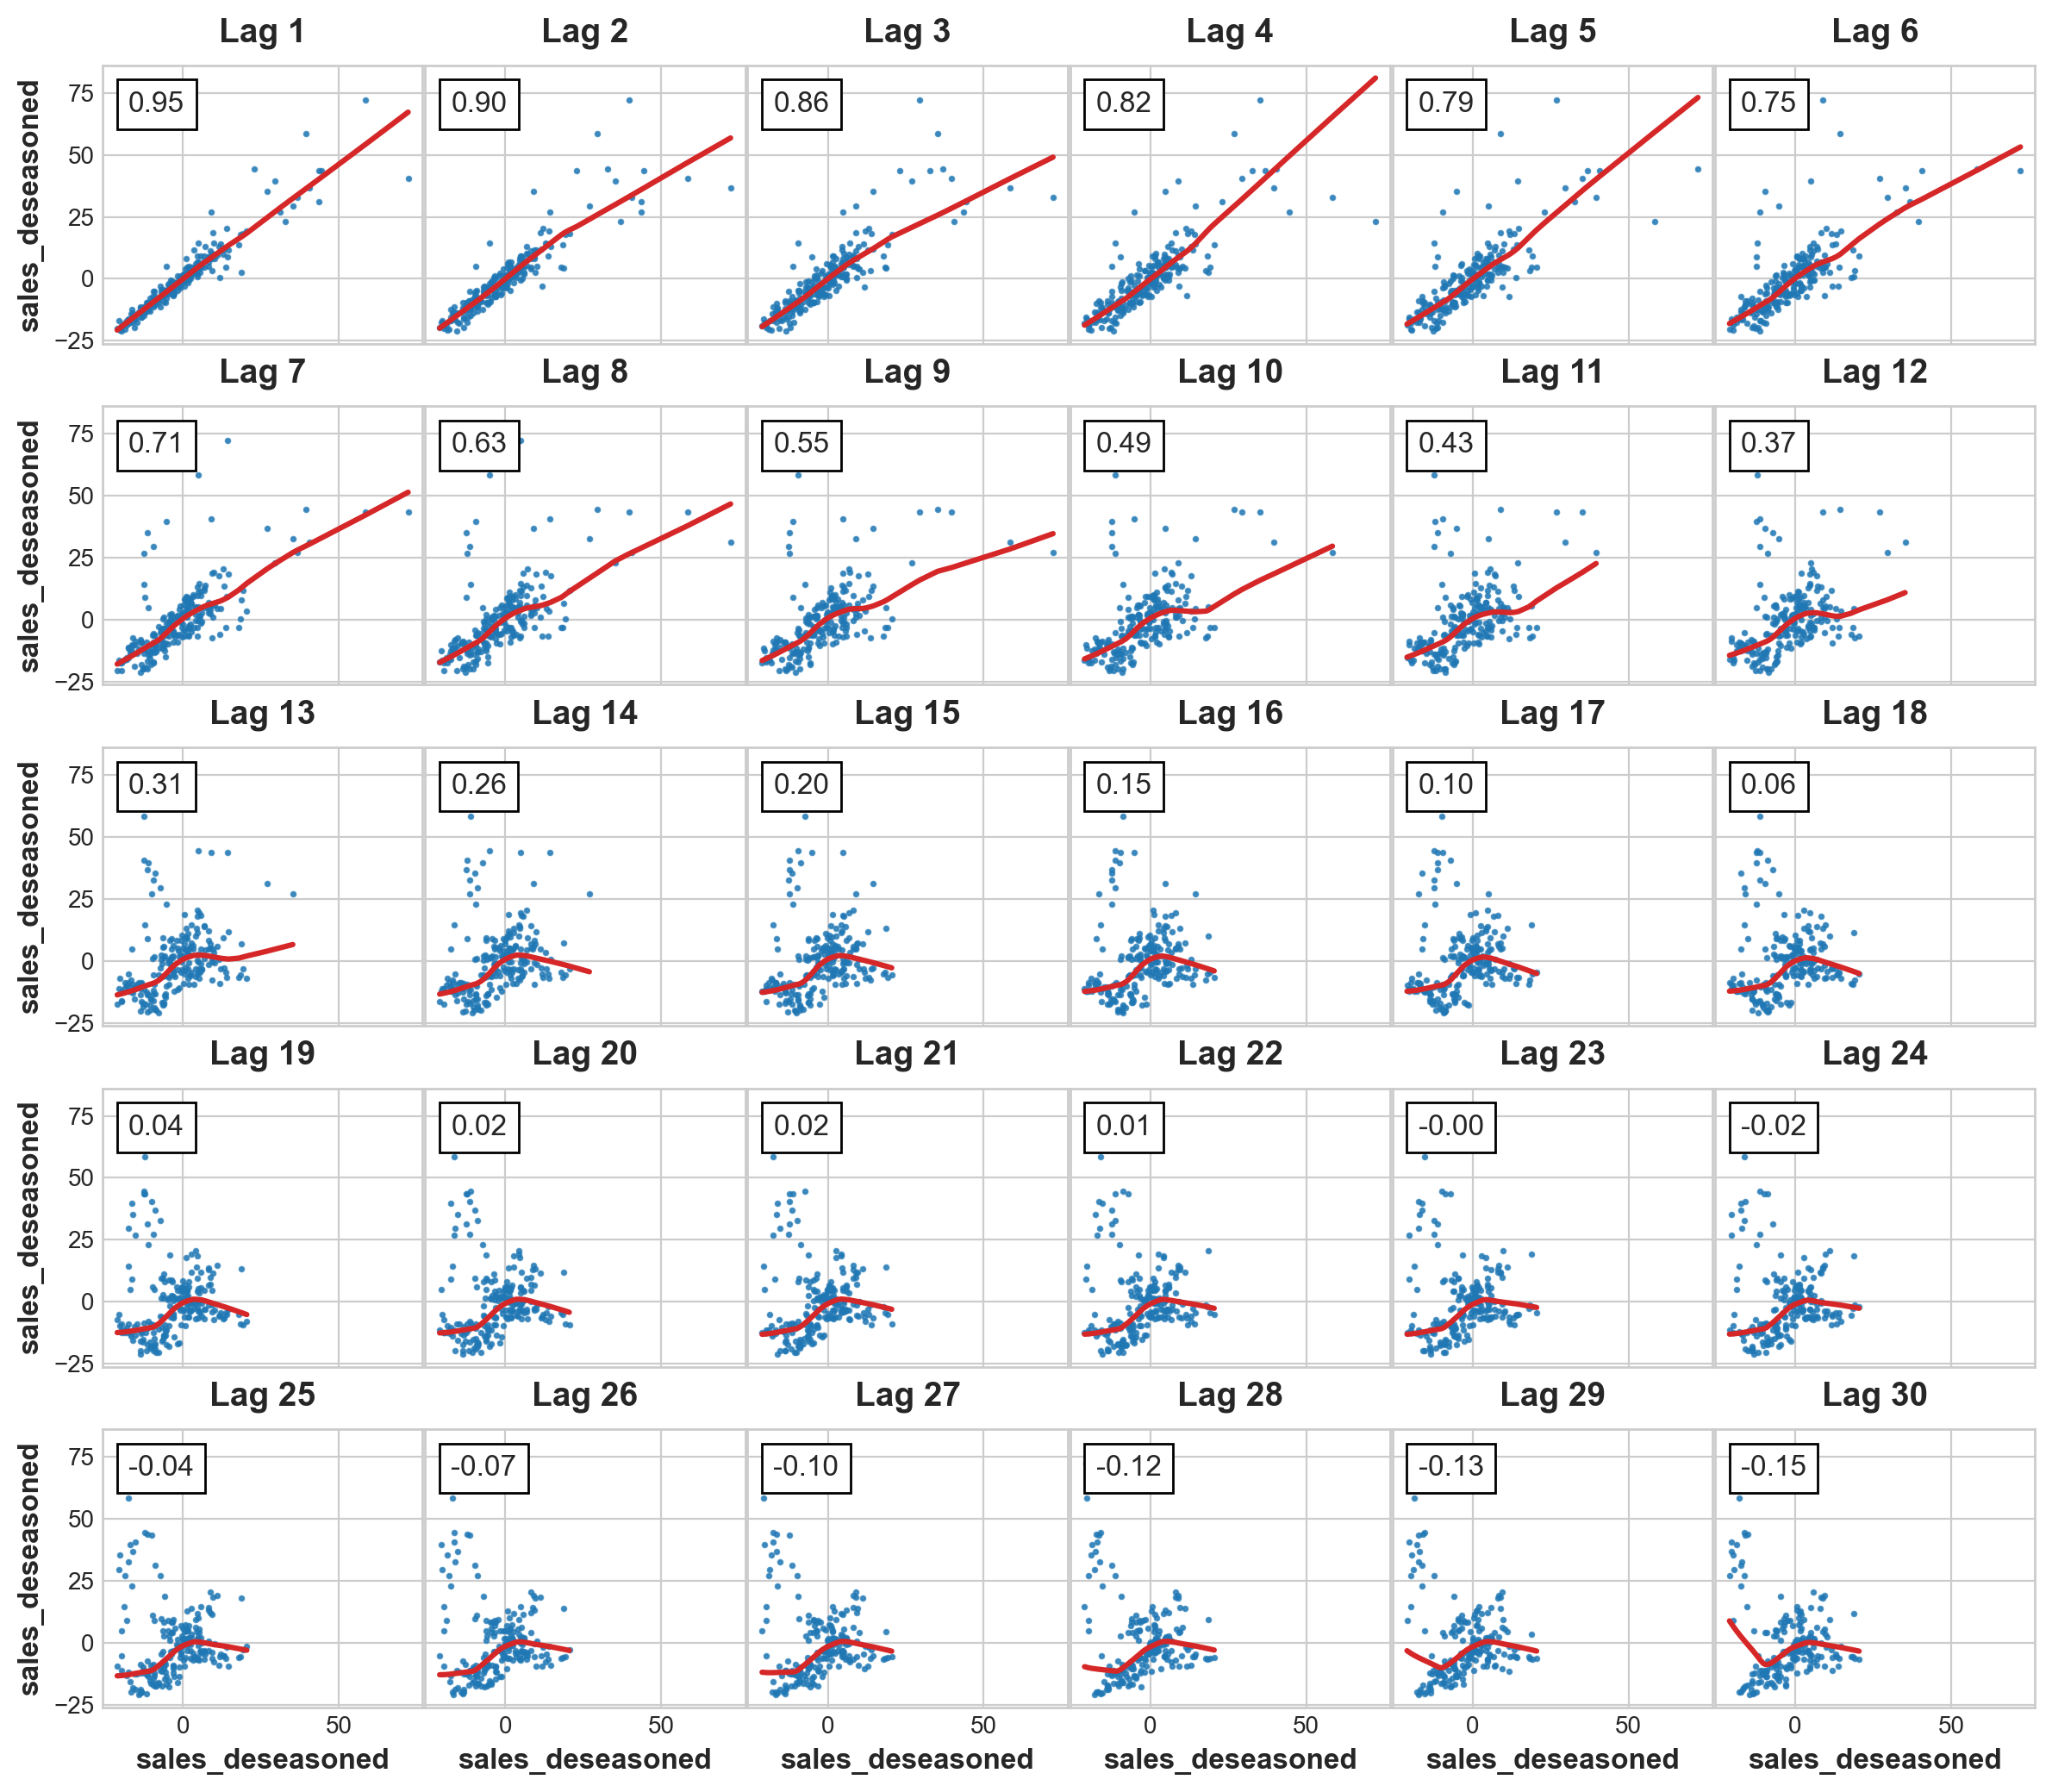

In [7]:
plot_pacf(y_deseason,lags=30);
plot_lags(y_deseason,lags = 30, nrows=5);

In [8]:
onpromotion = supply_sales.loc[:,'onpromotion'].squeeze().rename('onpromotion')

In [9]:
X_lags = make_lags(y_deseason, lags = [1,8])

X_promo = pd.concat([
    make_lags(onpromotion,lags=1),
    onpromotion,
    make_leads(onpromotion,leads=1),
    ],axis=1
    )

X = pd.concat([X_lags,X_promo], axis=1)
y, X = y.align(X,join='inner')

X.head()


,y_lag_1,y_lag_8,y_lag_1,onpromotion,y_lead_1
date,,,,,
2017-01-01,NaN,NaN,NaN,0.0,0.0
2017-01-02,-1.731948e-14,NaN,0.0,0.0,0.0
2017-01-03,1.362820e+00,NaN,0.0,0.0,0.0
2017-01-04,-1.724815e-01,NaN,0.0,0.0,0.0
2017-01-05,3.777271e-01,NaN,0.0,0.0,0.0


Training RMSLE: 0.67406
Validation RMSLE: 0.86314


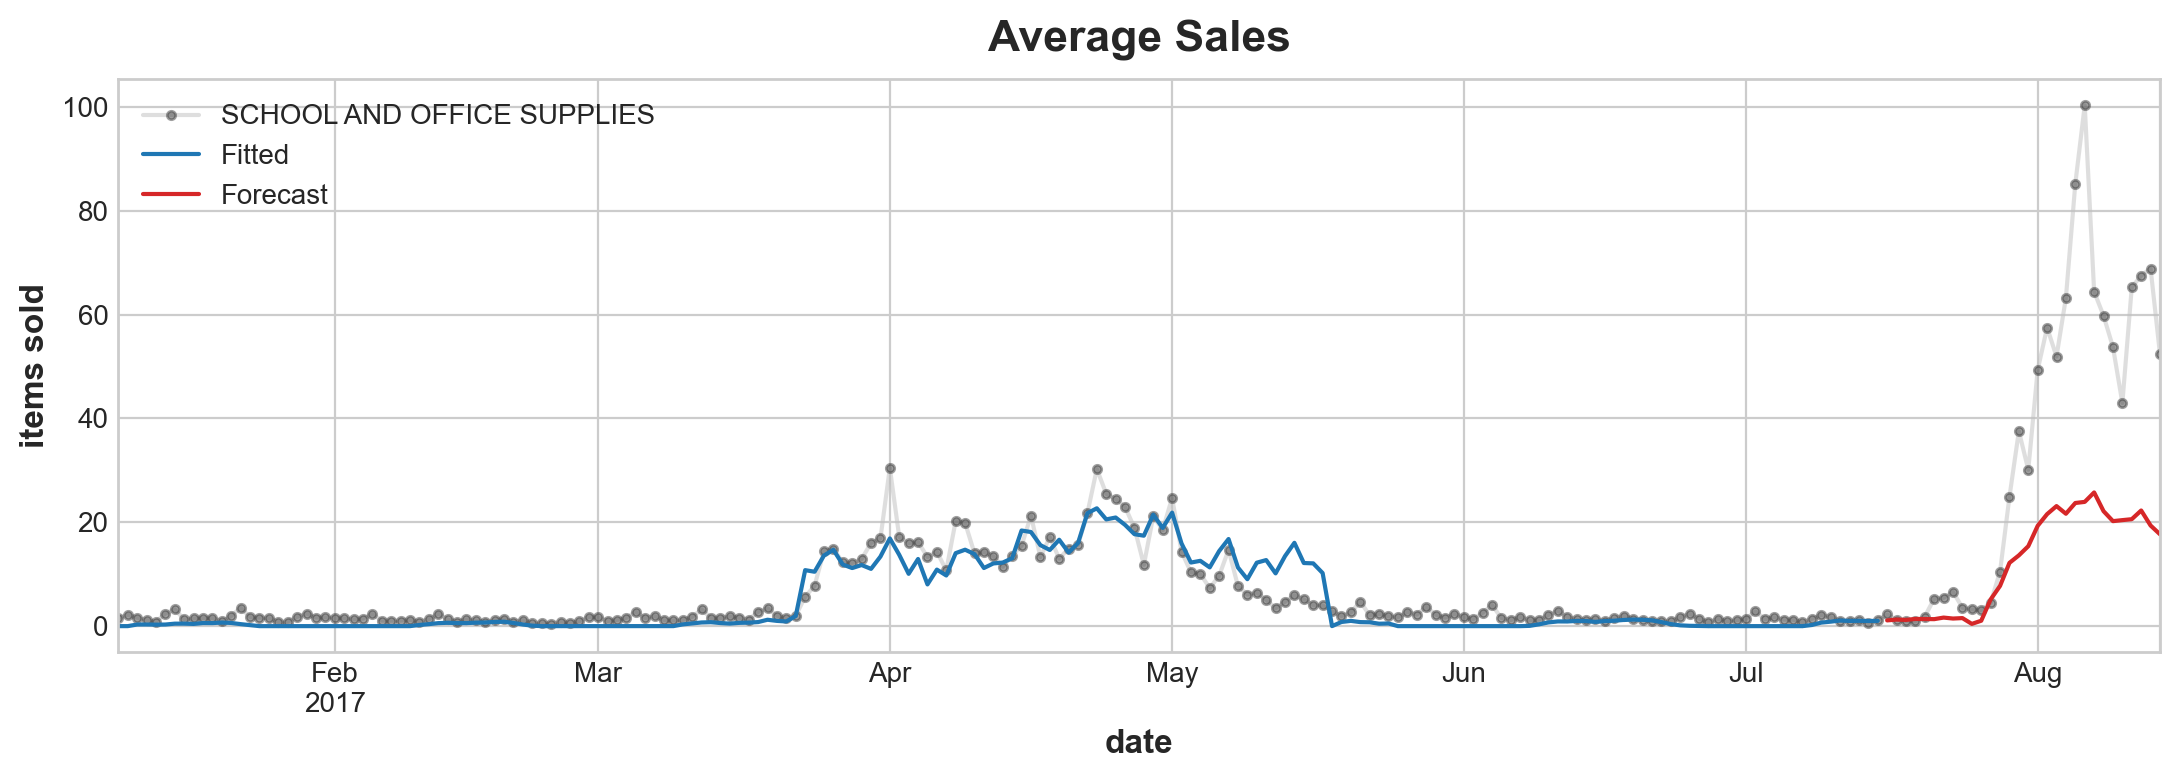

In [10]:
X = X.dropna()
y = y.loc[X.index]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend()